---
title: "6. Heston Model Real Data"
author: "Jordan Chong"
date: "2024-02-22"
format:
  html:
    theme: lux          # A clean, professional quantitative theme
    toc: true           # Adds a table of contents on the right
    toc-depth: 3
    number-sections: true
    code-fold: show     # Allows viewers to collapse/expand your Python code!
    code-tools: true
    df-print: paged     # Makes pandas DataFrames look beautiful
execute:
  warning: false        # Hides Python warnings from the final HTML
  echo: true            # Shows your code (crucial for a portfolio)
---

## Setup: Importing and Defining the State

In [1]:
import numpy as np
import warnings
import time
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt

# 1. Import your custom engine
from data_loader import MarketDataLoader
from quant_math_engine import heston_call_price, implied_volatility

# 2. Load Data (Only reads Parquet once)
BASE_DIR = r"G:\My Drive\00) Interview Prep\00) Quant\Data Sources\WRDS Data\Returns\Options"
loader = MarketDataLoader(BASE_DIR)

TARGET_DATE = '2024-01-10'
TARGET_EXDATE = '2024-02-16'
state = loader.get_market_state(TARGET_DATE, TARGET_EXDATE, strike_bound_pct=0.10)

S0, T, r, q = state['S0'], state['T'], state['r'], state['q']
market_strikes, market_prices = state['strikes'], state['prices']

# 3. Calculate Market IVs
target_ivs, valid_strikes = [], []
for i, K in enumerate(market_strikes):
    iv = implied_volatility(market_prices[i], S0, K, T, r, q)
    if not np.isnan(iv):
        target_ivs.append(iv)
        valid_strikes.append(K)

valid_strikes = np.array(valid_strikes)
target_ivs = np.array(target_ivs)
print(f"✅ Ready! Targeting {len(valid_strikes)} liquid strikes.")

Loading Options, Spot, Yield, and Dividend Data into memory...
✅ Data Loaded Successfully.
✅ Ready! Targeting 352 liquid strikes.


## Calibration of the Heston Model

In [6]:
sample_step = max(1, len(valid_strikes) // 40) 

target_strikes_sampled = valid_strikes[::sample_step]
target_ivs_sampled = target_ivs[::sample_step]

print(f"Downsampled from {len(valid_strikes)} to {len(target_strikes_sampled)} strikes for 10x faster optimization.")

# --- UPDATE YOUR OBJECTIVE FUNCTION TO USE THE SAMPLED ARRAYS ---
def heston_objective(params):
    v0, kappa, theta, xi, rho = params
    error = 0.0
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Loop through the SMALL array now
        for i, K in enumerate(target_strikes_sampled):
            m_price = heston_call_price(S0, K, T, r, q, v0, kappa, theta, xi, rho)
            m_iv = implied_volatility(m_price, S0, K, T, r, q)
            
            if np.isnan(m_iv): error += 5.0
            else: error += (m_iv - target_ivs_sampled[i])**2
                
    return error / len(target_strikes_sampled)

heston_bounds = [(0.01, 0.15), (0.5, 5.0), (0.01, 0.15), (0.05, 1.5), (-0.95, -0.4)]

print("Optimizing Heston Parameters (Hybrid Search)...")
start_time = time.time()

# Stage 1: Global Scout
res_global = differential_evolution(heston_objective, heston_bounds, popsize=8, maxiter=15, seed=42)

# Stage 2: Local Sniper
res_heston = minimize(heston_objective, res_global.x, method='L-BFGS-B', bounds=heston_bounds)

print(f"✅ Finished in {round(time.time() - start_time, 2)}s")
print(f"Optimal Parameters: {res_heston.x}")
print(f"Mean Squared Error: {res_heston.fun:.6f}")

Downsampled from 352 to 44 strikes for 10x faster optimization.
Optimizing Heston Parameters (Hybrid Search)...
✅ Finished in 144.73s
Optimal Parameters: [ 0.0146198   4.48319131  0.03773232  1.22309101 -0.63401892]
Mean Squared Error: 0.000040


## Visualising the Model against Live Data

Generating Heston Volatility Smile...


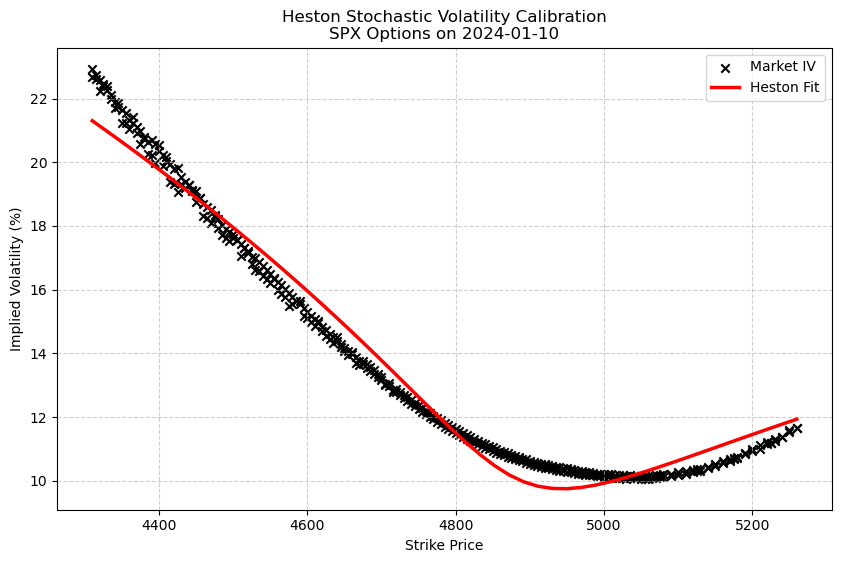

In [7]:
print("Generating Heston Volatility Smile...")

smooth_strikes = np.linspace(min(valid_strikes), max(valid_strikes), 50)
heston_prices = [heston_call_price(S0, k, T, r, q, *res_heston.x) for k in smooth_strikes]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    heston_iv = [implied_volatility(p, S0, k, T, r, q) for p, k in zip(heston_prices, smooth_strikes)]

valid_idx = ~np.isnan(heston_iv)
clean_strikes = np.array(smooth_strikes)[valid_idx]
clean_iv = np.array(heston_iv)[valid_idx] * 100

plt.figure(figsize=(10, 6))
plt.scatter(valid_strikes, target_ivs * 100, color='black', label='Market IV', marker='x')
plt.plot(clean_strikes, clean_iv, color='red', label='Heston Fit', linewidth=2.5)

plt.title(f"Heston Stochastic Volatility Calibration\nSPX Options on {TARGET_DATE}")
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility (%)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()